## Prepare a prediction model for profit of 50 startups data.
**Do transformations for getting better predictions of profit and make a table containing R^2 value for each prepared model.**

* **R&D Spend** -- Research and devolop spend in the past few years
* **Administration** -- spend on administration in the past few years
* **Marketing Spend** -- spend on Marketing in the past few years
* **State** -- states from which data is collected
* **Profit**  -- profit of each state in the past few years

### Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

### Importing Dataset

In [2]:
data = pd.read_csv(r'D:\Assignment ExcelR\Multi Linear Regression\50_Startups.csv')
data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [3]:
data.shape

(50, 5)

### Descriptive Analysis

In [4]:
data.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


### Checking for Data types

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


#### Observation: all the data types are correct .
* Note: State is a Categorical feature we need to do some encoding or convert it into numerical values by putting dummy values

In [6]:
startup_data = data.rename({'R&D Spend':'research','Administration':'admin','Marketing Spend':'marketing','State':'state','Profit':'profit'},axis=1)
startup_data.head()

,research,admin,marketing,state,profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


### Checking for missing values

In [7]:
startup_data.isna().sum()

research     0
admin        0
marketing    0
state        0
profit       0
dtype: int64

In [8]:
startup_data[startup_data.values==0.00]

,research,admin,marketing,state,profit
19,86419.70,153514.11,0.00,New York,122776.86
47,0.00,135426.92,0.00,California,42559.73
47,0.00,135426.92,0.00,California,42559.73
48,542.05,51743.15,0.00,New York,35673.41
49,0.00,116983.80,45173.06,California,14681.40


#### Observation: Notice there are some '0' values in the data in some features,
* here the context for Zero should be absolute Zero, no money has spend regards to that Department

### Checking for Duplicated Values

In [9]:
startup_data[startup_data.duplicated()].shape

(0, 5)

### Visualizing Continuous Datatype for Outlier Detection

In [10]:
continuous_feature = [feature for feature in startup_data.columns if startup_data[feature].dtype!='O']
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 4


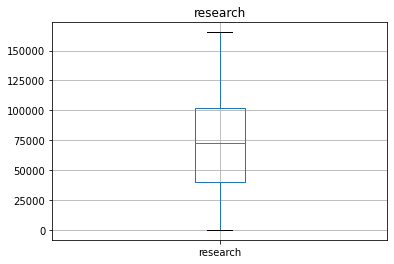

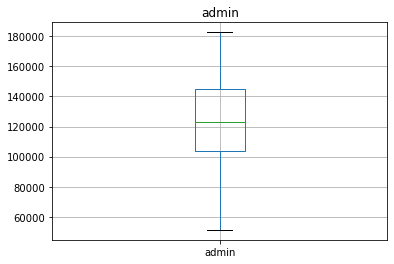

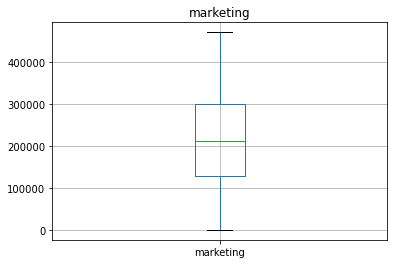

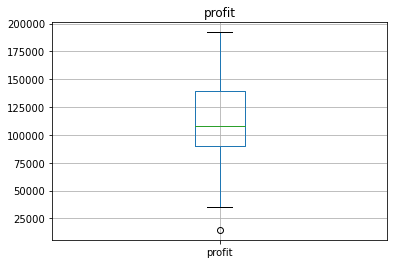

In [11]:
for feature in continuous_feature: 
    startup_data.boxplot(column=feature)
    plt.title(feature)
    plt.show()

#### Observation: There are Outlier in the Profit that is our Dependent Variable but there are no Outlier in our Dependent Features
* Note: we need to handle Outlier the best way sometime is to remove outliers from the dataset to stop them skewing our analysis, but that will lead to loss of information as we have a smaller dataset

### Let's try to find the Outliers in the Profit Dependent Variable
* Note: Transforming variables can also eliminate outliers. The Transformed Variables reduces the variation caused by the extreme values

In [12]:
Q1 = np.quantile(startup_data.profit,0.25)
Q3 = np.quantile(startup_data.profit,0.75)
med = np.median(startup_data.profit)
IQR = Q3 - Q1
upper_bound = Q3+(1.5*IQR)
lower_bound = Q1-(1.5*IQR)
print('First Quantile       :', Q1,'\n' 
      'Second Quantile      :', med,'\n'
      'Third Quantile       :', Q3,'\n'
      'Inter-Quartile Range :', IQR,'\n' 
      'Upper Whisker        :', upper_bound,'\n' 
      'Lower Whisker        :', lower_bound)

First Quantile       : 90138.9025 
Second Quantile      : 107978.19 
Third Quantile       : 139765.97749999998 
Inter-Quartile Range : 49627.07499999998 
Upper Whisker        : 214206.58999999997 
Lower Whisker        : 15698.290000000023


In [13]:
Outliers = startup_data.profit[(startup_data.profit <= lower_bound) | (startup_data.profit >= upper_bound)]
print('The outlier in the boxplot:',Outliers)

The outlier in the boxplot: 49    14681.4
Name: profit, dtype: float64


In [14]:
display(startup_data[startup_data.index.isin([49])])

,research,admin,marketing,state,profit
49,0.0,116983.8,45173.06,California,14681.4


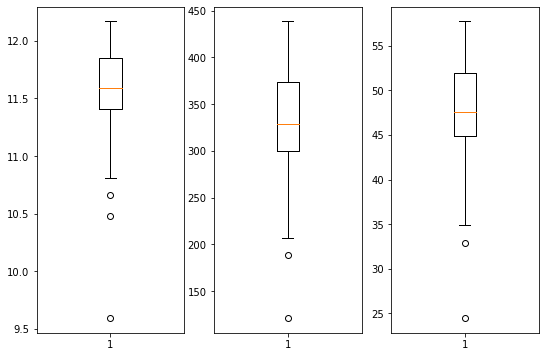

In [15]:
plt.subplots(figsize = (9,6))
plt.subplot(131)
plt.boxplot(np.log(startup_data['profit']))
plt.subplot(132)
plt.boxplot(np.sqrt(startup_data['profit']))
plt.subplot(133)
plt.boxplot(np.cbrt(startup_data['profit']))
plt.show()

#### Observation: Even After Transformation we are not able to remove the outliers.

### Before handling Outliers lets build a model and compare its R-squared value with other techniques to see which technique suits best for this case

### R-squared measures the strength of the relationship between your model and the dependent variable on a 0 – 100% scale.
### Measure goodness-of-fit by finding rsquared values (percentage of variance)

In [16]:
raw_model = smf.ols("profit ~ research + admin + marketing", data = startup_data).fit()
# Finding rsquared values
print('R-squared     :',raw_model.rsquared.round(3))
print('Adj.R-squared :',raw_model.rsquared_adj.round(3))

R-squared     : 0.951
Adj.R-squared : 0.948


### Let's try Median Imputation to handle Outlier in Profit

In [17]:
startup_data.profit.median()

107978.19

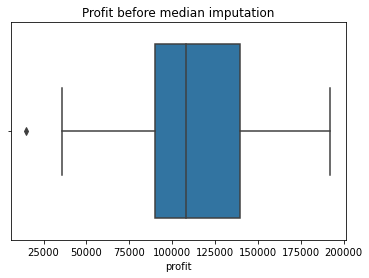

In [18]:
startup_data1 = startup_data.copy()
sns.boxplot(startup_data1['profit'])
plt.title('Profit before median imputation')
plt.show()

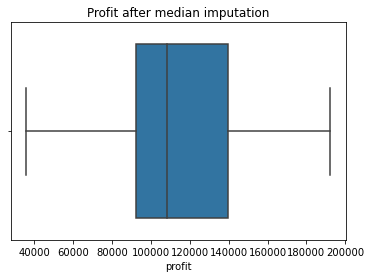

In [19]:
for i in startup_data1['profit']:
    q1 = np.quantile(startup_data1.profit,0.25)
    q3 = np.quantile(startup_data1.profit,0.75)
    med = np.median(startup_data1.profit)
    iqr = q3 - q1
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)
    if i > upper_bound or i < lower_bound:
        startup_data1['profit'] = startup_data1['profit'].replace(i, np.median(startup_data1['profit']))
sns.boxplot(startup_data1['profit'])
plt.title('Profit after median imputation')
plt.show()

### Let's test our data in model and compare the R-squared with Median imputation data model

In [20]:
median_imputation_model = smf.ols("profit ~ research + admin + marketing", data = startup_data1).fit()
# Finding rsquared values
print('R-squared     :',median_imputation_model.rsquared.round(3))
print('Adj.R-squared :',median_imputation_model.rsquared_adj.round(3))

R-squared     : 0.918
Adj.R-squared : 0.913


#### Observation: As you can see after median imputation the model is not performing well
* Now we have to try something else to get out better results than the raw data

### Let's try Mean Imputation to handle Outlier in Profit

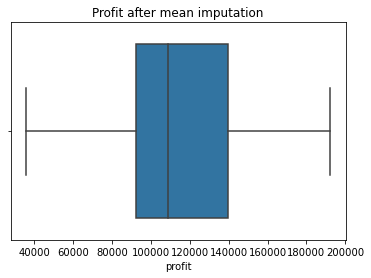

In [21]:
startup_data2 = startup_data.copy()
for i in startup_data2['profit']:
    q1 = np.quantile(startup_data2.profit,0.25)
    q3 = np.quantile(startup_data2.profit,0.75)
    med = np.median(startup_data2.profit)
    iqr = q3 - q1
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)
    if i > upper_bound or i < lower_bound:
        startup_data2['profit'] = startup_data2['profit'].replace(i, np.mean(startup_data2['profit']))
sns.boxplot(startup_data2['profit'])
plt.title('Profit after mean imputation')
plt.show()

### Let's test our data in model and compare the R-squared with Mean imputation data model

In [22]:
mean_imputation_model = smf.ols("profit ~ research + admin + marketing", data = startup_data2).fit()
# Finding rsquared values
print('R-squared     :',mean_imputation_model.rsquared.round(3))
print('Adj.R-squared :',mean_imputation_model.rsquared_adj.round(3))

R-squared     : 0.912
Adj.R-squared : 0.906


#### Observation: As you can see after mean imputation the model is not performing well it got a little worse than the median one
* Now we have to try something else to get out better results than the raw data

### The best thing we can do is now to remove the outlier and see the results

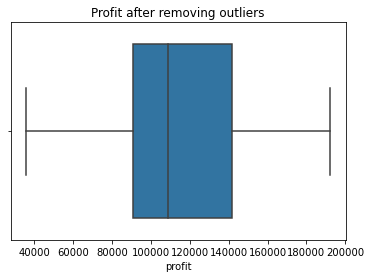

In [23]:
startup_data3 = startup_data.copy()
def drop_outliers(startup_data3, field_name):
    iqr = 1.5*(np.percentile(startup_data3[field_name], 75) - np.percentile(startup_data3[field_name], 25))
    startup_data3.drop(startup_data3[startup_data3[field_name] > (iqr + np.percentile(startup_data3[field_name], 75))].index, inplace=True)
    startup_data3.drop(startup_data3[startup_data3[field_name] < (np.percentile(startup_data3[field_name], 25) - iqr)].index, inplace=True)
drop_outliers(startup_data3, 'profit')
sns.boxplot(startup_data3.profit)
plt.title('Profit after removing outliers')
plt.show()

### Let's test our data in model and compare the R-squared with and without imputation data models

In [24]:
removed_outlier_model = smf.ols("profit ~ research + admin + marketing", data = startup_data3).fit()
# Finding rsquared values
print('R-squared     :',removed_outlier_model.rsquared.round(3))
print('Adj.R-squared :',removed_outlier_model.rsquared_adj.round(3))

R-squared     : 0.961
Adj.R-squared : 0.959


#### Observation: A Slightly better score than the raw data model
* ### Note: We will continue with this data set

### Exploratory Data Anlaysis
### Visualizing the Distribution of Independent Features with the help of Histograms

In [25]:
import pylab
def plot_data(data,feature):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    data[feature].hist()
    plt.subplot(1,2,2)
    stat.probplot(data[feature],dist='norm',plot=pylab)

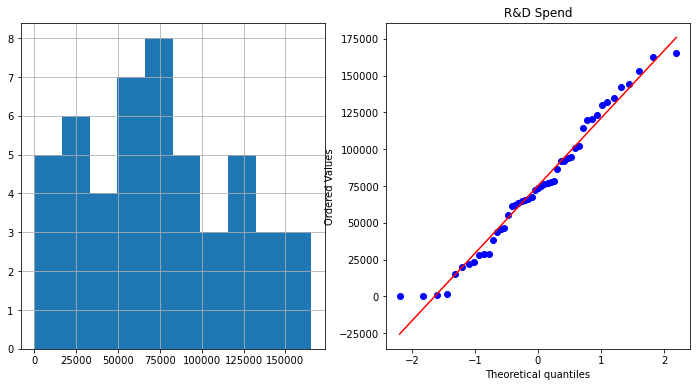

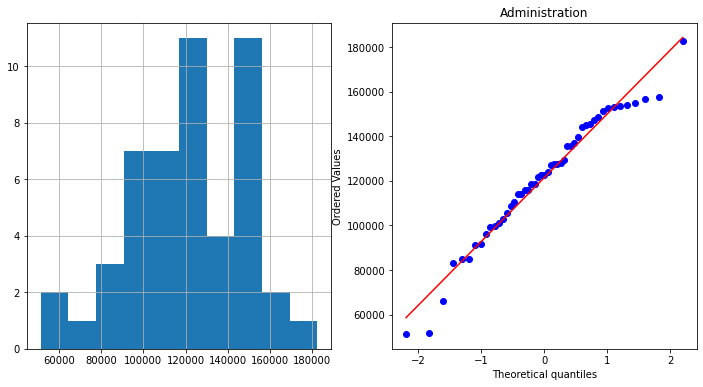

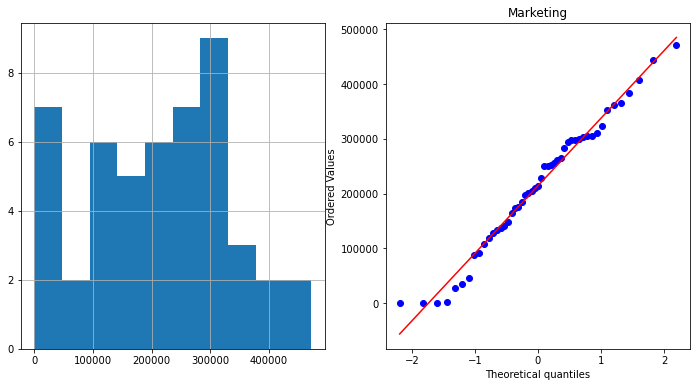

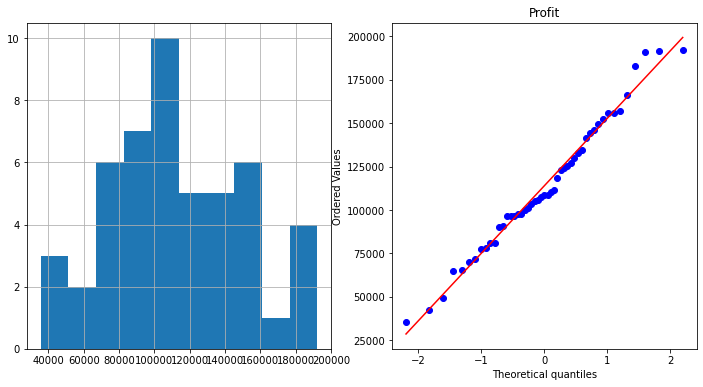

In [26]:
plot_data(startup_data3,'research')
plt.title('R&D Spend')
plot_data(startup_data3,'admin')
plt.title('Administration')
plot_data(startup_data3,'marketing')
plt.title('Marketing')
plot_data(startup_data3,'profit')
plt.title('Profit')
plt.show()

### Square root transformation and visualizing the Histogram to determine any possible changes in distribution

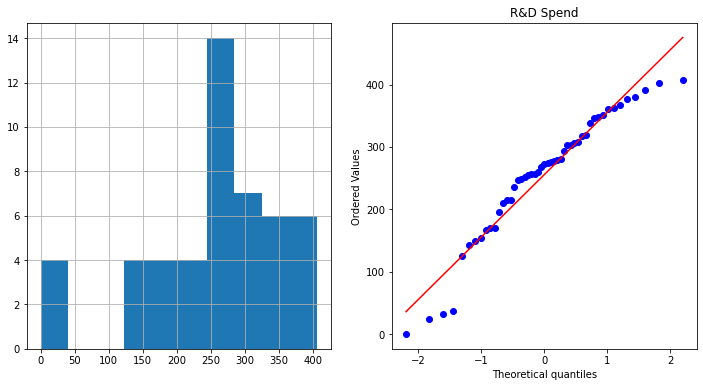

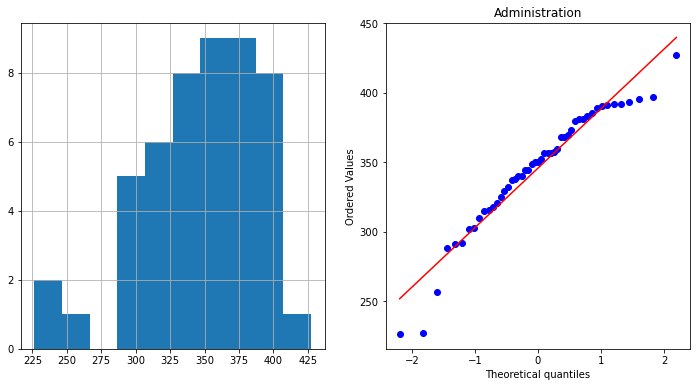

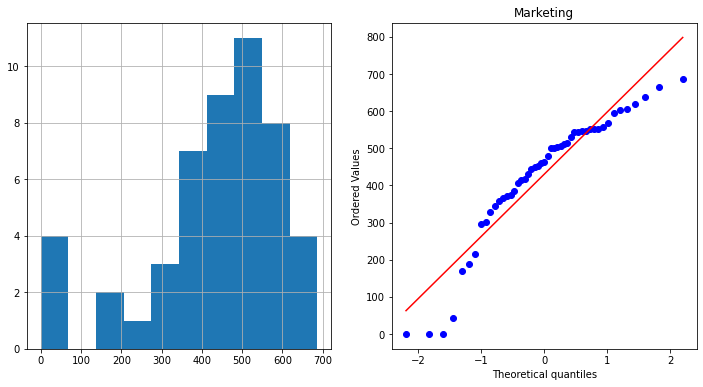

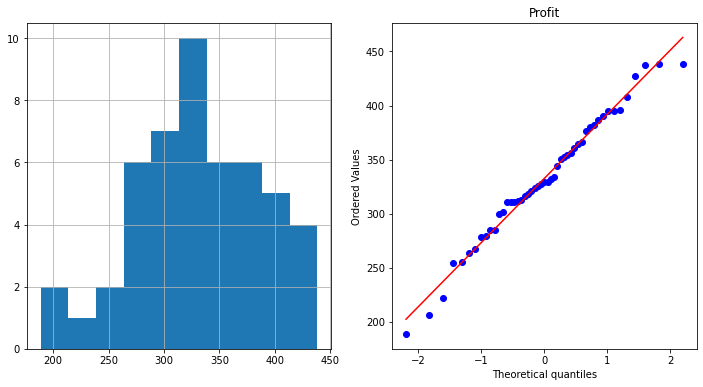

In [27]:
data_sqrt = startup_data3.copy()
data_sqrt[continuous_feature]=np.sqrt(data_sqrt[continuous_feature])

plot_data(data_sqrt,'research')
plt.title('R&D Spend')
plot_data(data_sqrt,'admin')
plt.title('Administration')
plot_data(data_sqrt,'marketing')
plt.title('Marketing')
plot_data(data_sqrt,'profit')
plt.title('Profit')
plt.show()

### Cuberoot transformation and visualizing the Histogram to determine any possible changes in distribution

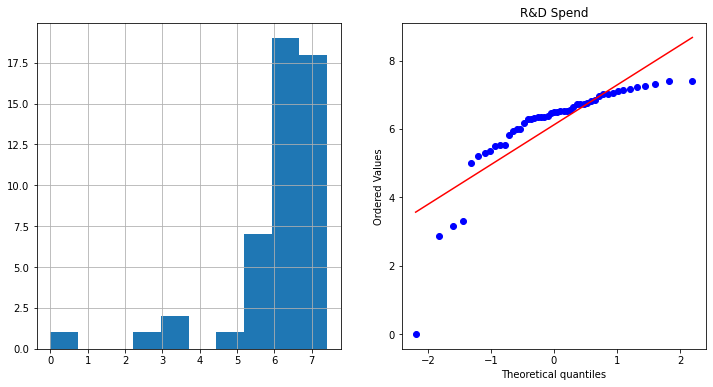

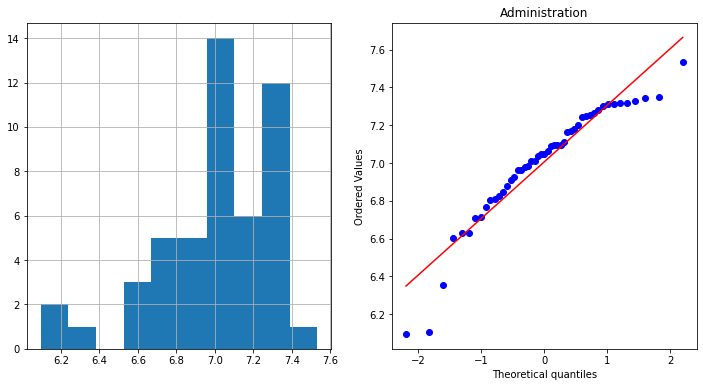

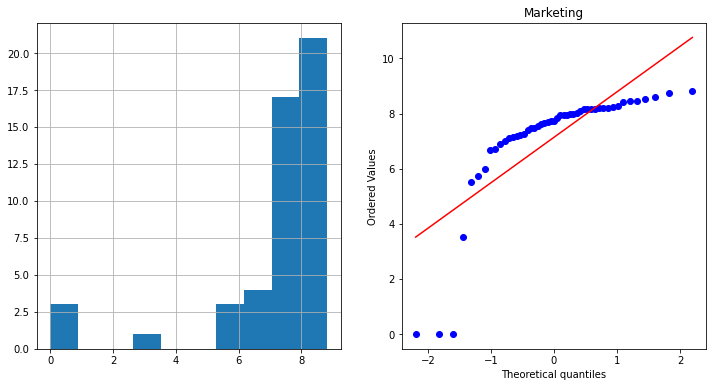

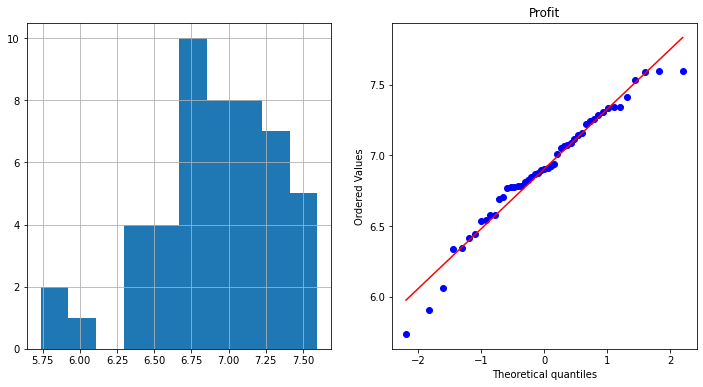

In [28]:
data_cbrt = startup_data3.copy()
data_cbrt[continuous_feature]=np.cbrt(data_sqrt[continuous_feature])

plot_data(data_cbrt,'research')
plt.title('R&D Spend')
plot_data(data_cbrt,'admin')
plt.title('Administration')
plot_data(data_cbrt,'marketing')
plt.title('Marketing')
plot_data(data_cbrt,'profit')
plt.title('Profit')
plt.show()

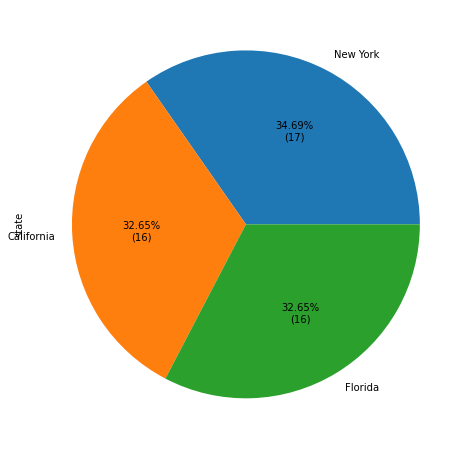

In [29]:
plt.figure(figsize=(8,8))
startup_data3['state'].value_counts().plot(kind='pie',autopct=lambda p:'{:.2f}%\n({:.0f})'.format(p,(p/100)*(startup_data3['state'].value_counts().sum())))
plt.show()

#### Observation: The Categorical State Feature has balanced data all the unique values are approximately equally distributed
* Note: Most of the Continuous Features visually look normally distributed without any transformation lets have some Hypothetical test to check the normality.

### The Shapiro-Wilk test is a test of normality. It is used to determine whether or not a sample comes from a normal distribution.

In [30]:
startup_data3.columns

Index(['research', 'admin', 'marketing', 'state', 'profit'], dtype='object')

In [31]:
from scipy.stats import shapiro

#perform Shapiro-Wilk test
print('R&D Spend feature      :',shapiro(startup_data3.research),'\n'
      'Administration feature :',shapiro(startup_data3.admin),'\n'
      'Marketing Spend feature:',shapiro(startup_data3.marketing),'\n'
      'Profit feature         :',shapiro(startup_data3.profit))

R&D Spend feature      : ShapiroResult(statistic=0.9705318212509155, pvalue=0.2542237639427185) 
Administration feature : ShapiroResult(statistic=0.9695432186126709, pvalue=0.23222382366657257) 
Marketing Spend feature: ShapiroResult(statistic=0.9757168889045715, pvalue=0.401671826839447) 
Profit feature         : ShapiroResult(statistic=0.9793398380279541, pvalue=0.537902295589447)


#### Observation: Since the p-values are not less than .05, we fail to reject the null hypothesis.
* We do not have sufficient evidence to say that the sample data does not come from a normal distribution.

### Visualizing the Relation between each independent Feature with respect to the Dependent Feature

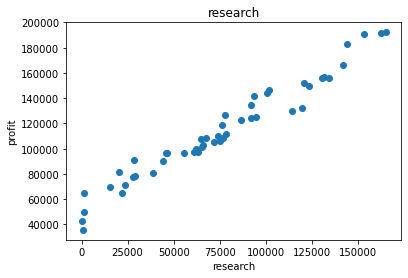

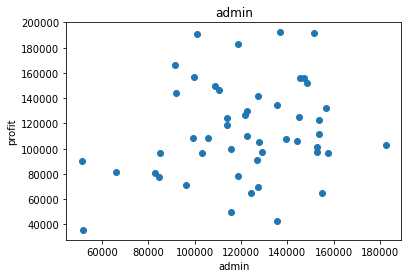

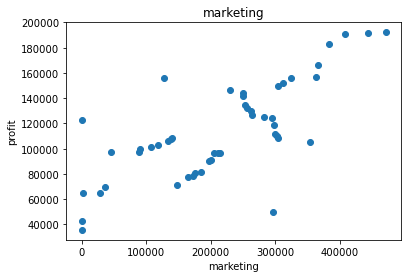

In [32]:
for feature in continuous_feature:
    if feature!="profit":
        data = startup_data3.copy()         
        plt.scatter(data[feature],data['profit'])
        plt.xlabel(feature)
        plt.ylabel('profit')
        plt.title(feature)
        plt.show()

#### Observation: R&D feature has a good linear relation with Profit as compare to other features

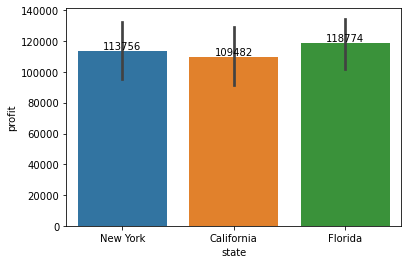

In [33]:
bp = sns.barplot(x = "state", y = 'profit', data = startup_data3)
for i in bp.containers:
    bp.bar_label(i,)

#### Observation: There is not much of difference between how much profit each state generates from each other and there is not any direct relation
* Note: We are going to drop this feature while building model as it is an irrelevant feature for our inferences

In [34]:
startup_data4 = startup_data3.drop('state',axis=1)
startup_data4.head()

,research,admin,marketing,profit
0,165349.20,136897.80,471784.10,192261.83
1,162597.70,151377.59,443898.53,191792.06
2,153441.51,101145.55,407934.54,191050.39
3,144372.41,118671.85,383199.62,182901.99
4,142107.34,91391.77,366168.42,166187.94


### Checking the correlation between Variables

In [35]:
startup_data4.corr()

,research,admin,marketing,profit
research,1.000000,0.243438,0.711654,0.978437
admin,0.243438,1.000000,-0.037280,0.205841
marketing,0.711654,-0.037280,1.000000,0.739307
profit,0.978437,0.205841,0.739307,1.000000


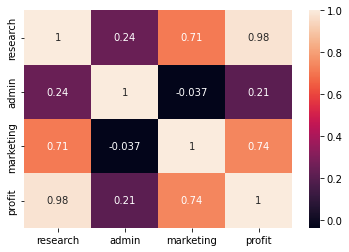

In [36]:
sns.heatmap(startup_data4.corr(),annot=True)
plt.show()

### Plotting Correlation on a Pair Plot

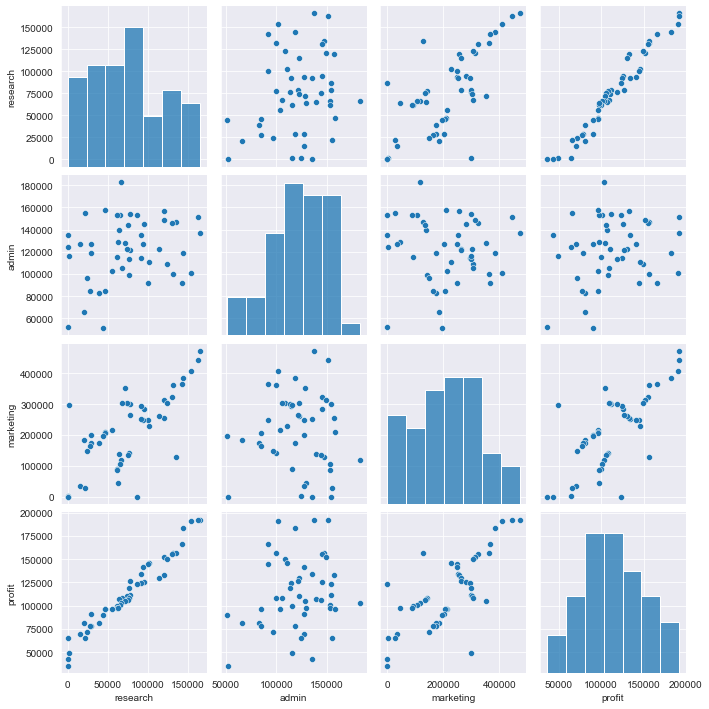

In [37]:
sns.set_style(style='darkgrid')
sns.pairplot(startup_data4)
plt.show()

#### Observation: R&D has the highest score of correlation and the linear relation with Profit

* Note: Marketing and R&D also have a collinearity among themselves which will affect our model.

### Feature Engineering
### Applying some Data Transformation to increase the linear realtionship and improve our model prediction as well it scores
### Applying Standard Scaler
* For each feature, the Standard Scaler scales the values such that the mean is 0 and the standard deviation is 1(or the variance).
* x_scaled = x – mean/std_dev
* However, Standard Scaler assumes that the distribution of the variable is normal. Thus, in case, the variables are not normally distributed, we either choose a different scaler or first, convert the variables to a normal distribution and then apply this scaler

In [38]:
data_standard_scaled = startup_data4.copy()
features = data_standard_scaled[continuous_feature]

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data_standard_scaled[continuous_feature] = scaler.fit_transform(features.values)
data_standard_scaled.head()

,research,admin,marketing,profit
0,2.018325,0.552080,2.146120,2.071556
1,1.956704,1.069017,1.913596,2.059122
2,1.751650,-0.724297,1.613709,2.039490
3,1.548545,-0.098597,1.407457,1.823808
4,1.497818,-1.072513,1.265442,1.381401


### Now if we check the mean and standard deviation of our scaled data it should have a Mean '0' and Standard deviation '1'

In [40]:
print('Mean' '\n',np.round(data_standard_scaled.mean(),1),'\n' 'Standard Devaition','\n',np.round(data_standard_scaled.std()),1)

Mean
 research     0.0
admin       -0.0
marketing   -0.0
profit      -0.0
dtype: float64 
Standard Devaition 
 research     1.0
admin        1.0
marketing    1.0
profit       1.0
dtype: float64 1


### For building Multi Linear Resgression there are assumption regarding the data set.

**They are as follows:-**
* Feature should be independent of each other there should'nt be any dependency upon each other
* There shouldn't be any other relation but Linear relation amongst model parameters (Hyperparameters of the model the intercept and coefficient)
* Each Feature and Model Error (residuals) should be independent of each other
* Constant Variance (Homoscedasticity) in Error, it should have Normal / Gaussian distribution~N(0,1) and idenpendently and identically distributed.
* There should be a linear relation between the dependent variable and Independent variables

**Note: If any of the above step is not followed our model can't be a good predictor**

**We will Check the above one by one**

### Preparing a Model

In [41]:
model = smf.ols("profit ~ research + admin + marketing", data = data_standard_scaled).fit()
# Finding rsquared values
print('R-squared     :',removed_outlier_model.rsquared.round(3))
print('Adj.R-squared :',removed_outlier_model.rsquared_adj.round(3))

R-squared     : 0.961
Adj.R-squared : 0.959


### Model Testing
**As ŷ = β0 + β1(x1) + β2(x2) + β3(x3) + … + βk(xk)**

### Finding Coefficient Parameters (Beta0 and Beta1's values)

In [42]:
model.params

Intercept   -1.838807e-16
research     9.254411e-01
admin       -1.646059e-02
marketing    8.009988e-02
dtype: float64

Assupmtion for multi linear Regression fails

Feature should be independent of each other there should'nt be any dependency upon each other

### Finding tvalues and pvalues

In [43]:
display(np.round(model.tvalues,3), np.round(model.pvalues,3))

Intercept    -0.000
research     20.470
admin        -0.518
marketing     1.825
dtype: float64

Intercept    1.000
research     0.000
admin        0.607
marketing    0.075
dtype: float64

#### Here, (Intercept) Beta0 p_value ~ 1
**Hypothesis testing of X variable by finding test_statistics and P_values for Beta1 i.e if (P_value < α=0.05 ; Reject Null)**

**Null Hypothesis as Beta1=0 (No Slope) and Alternate Hypthesis as Beta1≠0 (Some or significant Slope)**

#### Observation:
* (Intercept) Beta0: tvalue=-0.000 , pvalue=1.000
* (RnD) Beta1: tvalue=20.470, pvalue= 0.000
* (admin) Beta2: tvalue=-0.518, pvalue= 0.607
* (marketing) Beta3: tvalue=1.825, pvalue= 0.075
* If (pvalue=0)<(α=0.05); Reject Null hyp. Thus, X(RnD) variable has good slope and variance w.r.t Y(profit) variable.
* If (pvalue=0)>(α=0.05); We fail to reject Null hyp. Thus, X1(admin) and X2(marketing) variable doesn't have good slope
* Until further tests

#### Note:

* We are now going to perform Simple Linear Regression to separately check the dependency between those feature with Target feature
* Let's first compare models by their R-Squared and p_values.

In [44]:
admin_slr_model = smf.ols("profit ~ admin", data = data_standard_scaled).fit()

#### Finding rsquared values

In [45]:
print('R-squared     :',admin_slr_model.rsquared.round(3))
print('Adj.R-squared :',admin_slr_model.rsquared_adj.round(3))

R-squared     : 0.042
Adj.R-squared : 0.022


#### Finding tvalues and pvalues

In [46]:
display(np.round(admin_slr_model.tvalues,3), np.round(admin_slr_model.pvalues,3))

Intercept   -0.000
admin        1.442
dtype: float64

Intercept    1.000
admin        0.156
dtype: float64

#### Observation:
* (Intercept) Beta0: tvalue=-0.000 , pvalue=1.000
* (admin) Beta1: tvalue=1.442, pvalue= 0.156
* If (pvalue=0)<(α=0.05); Reject Null hyp.
* If (pvalue=0)>(α=0.05); We fail to reject Null hyp. Thus, X(admin) variable doesn't has good slope Until further tests

In [47]:
marketing_slr_model = smf.ols("profit ~ marketing", data = data_standard_scaled).fit()

#### Finding rsquared values

In [48]:
print('R-squared     :',marketing_slr_model.rsquared.round(3))
print('Adj.R-squared :',marketing_slr_model.rsquared_adj.round(3))

R-squared     : 0.547
Adj.R-squared : 0.537


#### Finding tvalues and pvalues

In [49]:
display(np.round(marketing_slr_model.tvalues,3), np.round(marketing_slr_model.pvalues,3))

Intercept   -0.000
marketing    7.527
dtype: float64

Intercept    1.0
marketing    0.0
dtype: float64

#### Observation:
* (Intercept) Beta0: tvalue=-0.000 , pvalue=1.000
* (marketing) Beta1: tvalue=7.527, pvalue= 0.0
* If (pvalue=0)<(α=0.05); Reject Null hyp. Thus, X(marketing) variable has good slope
* If (pvalue=0)>(α=0.05); We fail to reject Null hypothesis Until further tests

###  So if we combine admin and marketing feature to predict profit we should get a total R-sqaure value of 58% right?
### lets check

### Finding rsquared values

In [50]:
admin_plus_marketing = smf.ols('profit ~ admin + marketing', data =data_standard_scaled).fit()

In [51]:
print('R-squared     :',admin_plus_marketing.rsquared.round(3))
print('Adj.R-squared :',admin_plus_marketing.rsquared_adj.round(3))

R-squared     : 0.601
Adj.R-squared : 0.584


### Let's Try another Test by Calculating VIF ( Variance Inflation Factor )
* This helps to check the dependency among the features by building a model without the target and testing various combination among the features

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
x = startup_data4[['marketing','admin','research']]
vif_data = pd.DataFrame()
vif_data['Features'] = x.columns
vif_data['VIF'] = [vif(x.values, i) for i in range(len(x.columns))]
vif_data.sort_values(by = ['VIF'])

,Features,VIF
1,admin,4.218831
0,marketing,7.589312
2,research,8.602235


In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
x = startup_data4[['marketing','research']]
vif_data = pd.DataFrame()
vif_data['Features'] = x.columns
vif_data['VIF'] = [vif(x.values, i) for i in range(len(x.columns))]
vif_data.sort_values(by = ['VIF'])

,Features,VIF
0,marketing,7.186744
1,research,7.186744


#### Some of the variables has VIF>5, Yes there is Collinearity, hence we cannot consider all varaibles in Regression equation

#### Observation: As we can observe this test is not giving us much of an information to come up to an conclusion
* Let's try another approach that will justify our first test we conducted

### Let's build two model in each model one of the feature will not be present and then we will come to an conclusion to remove which of the feature by comparing the model parameters

In [54]:
startup_data4.head(1)

,research,admin,marketing,profit
0,165349.2,136897.8,471784.1,192261.83


In [55]:
admin_present_model = smf.ols('profit ~ research + admin', data= data_standard_scaled).fit()
print('R-squared     :',admin_present_model.rsquared.round(3))
print('Adj.R-squared :',admin_present_model.rsquared_adj.round(3))
print('AIC Value     :',admin_present_model.aic.round(3))
print('BIC Value     :',admin_present_model.bic.round(3))
print('P-Value       :\n',admin_present_model.pvalues)

R-squared     : 0.958
Adj.R-squared : 0.957
AIC Value     : -10.808
BIC Value     : -5.133
P-Value       :
 Intercept    1.000000e+00
research     5.451979e-33
admin        2.728844e-01
dtype: float64


eval_env: 1


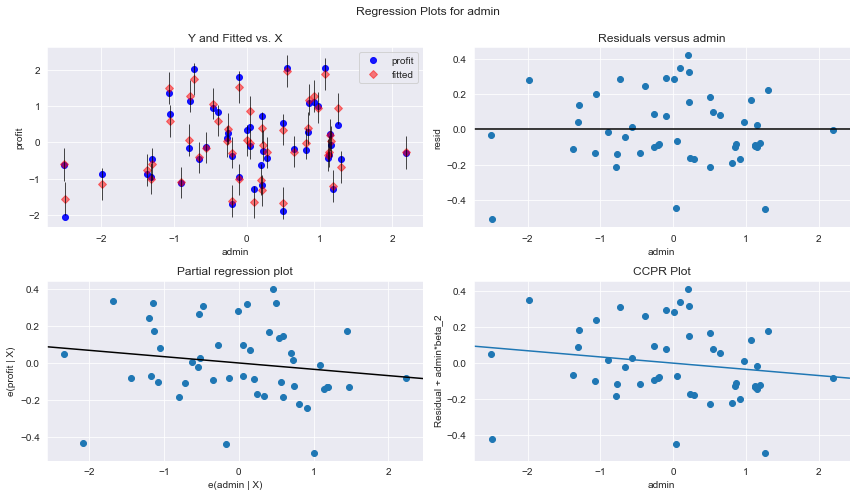

In [56]:
fig = plt.figure(figsize = (12,7))
sm.graphics.plot_regress_exog(admin_present_model, 'admin', fig=fig)
plt.show()

In [57]:
marketing_present_model = smf.ols('profit ~ research + marketing', data= data_standard_scaled).fit()
print('R-squared     :',marketing_present_model.rsquared.round(3))
print('Adj.R-squared :',marketing_present_model.rsquared_adj.round(3))
print('AIC Value     :',marketing_present_model.aic.round(3))
print('BIC Value     :',marketing_present_model.bic.round(3))
print('P-Value       :\n',marketing_present_model.pvalues)

R-squared     : 0.961
Adj.R-squared : 0.959
AIC Value     : -14.017
BIC Value     : -8.342
P-Value       :
 Intercept    1.000000e+00
research     3.628510e-26
marketing    4.084443e-02
dtype: float64


eval_env: 1


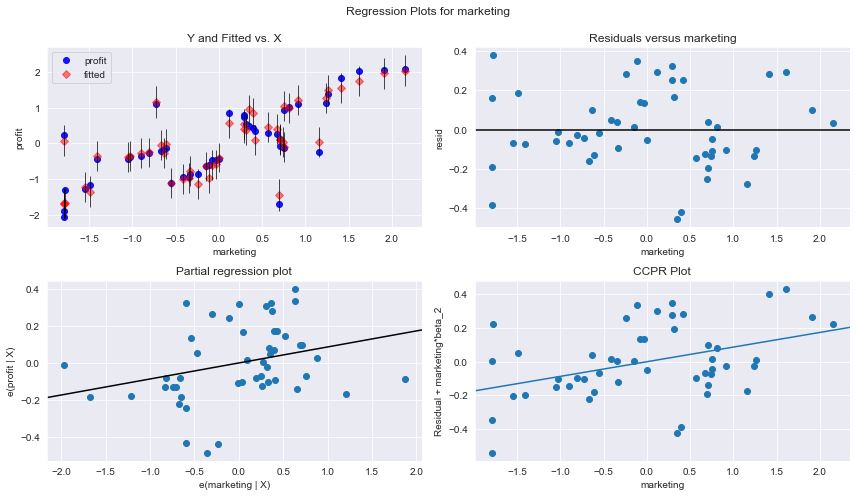

In [58]:
fig = plt.figure(figsize = (12,7))
sm.graphics.plot_regress_exog(marketing_present_model, 'marketing', fig=fig)
plt.show()

In [59]:
research_model = smf.ols('profit ~ research', data= data_standard_scaled).fit()
print('R-squared     :',research_model.rsquared.round(3))
print('Adj.R-squared :',research_model.rsquared_adj.round(3))
print('AIC Value     :',research_model.aic.round(3))
print('BIC Value     :',research_model.bic.round(3))
print('P-Value       :\n',research_model.pvalues)

R-squared     : 0.957
Adj.R-squared : 0.956
AIC Value     : -11.514
BIC Value     : -7.73
P-Value       :
 Intercept    1.000000e+00
research     7.555104e-34
dtype: float64


eval_env: 1


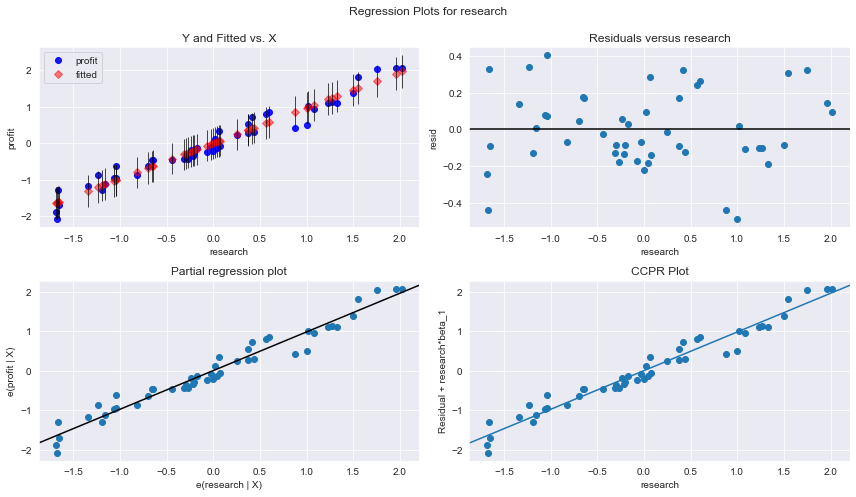

In [60]:
fig = plt.figure(figsize = (12,7))
sm.graphics.plot_regress_exog(research_model, 'research', fig=fig)
plt.show()

#### Observation: All our Assumptions are satisfied by the above model
* Feature should be independent of each other there should'nt be any dependency upon each other
* it is satisfied by the model using Marketing feature
* While building a model using Marketing we got better results better AIC, BIC, R-squared, R-squared adjusted, p_value(Test of Independence) and F-statistics score by comparing it with the model in which Adminstration feature was used.

### Let's compare the residuals of both the models to come up with an conclusion

### Model Validation
**Comparing different models with respect to their Root Mean Squared Errors**

**We will analyze Mean Squared Error (MSE) or Root Mean Squared Error (RMSE) — AKA the average distance (squared to get rid of negative numbers) between the model’s predicted target value and the actual target value.**

In [61]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [62]:
startup_data.columns

Index(['research', 'admin', 'marketing', 'state', 'profit'], dtype='object')

### Using all features

In [63]:
x = startup_data4.drop('profit', axis = 1).values
y = startup_data4.iloc[:,3:].values.reshape(-1,1)
print("Shape of x : ",x.shape)
print("Shape of y : ",y.shape)

Shape of x :  (49, 3)
Shape of y :  (49, 1)


####  Splitting the dataset into the Training set and Test set

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 13)
print("Shape of X_train : ",x_train.shape)
print("Shape of X_test  : ", x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Shape of X_train :  (39, 3)
Shape of X_test  :  (10, 3)
Shape of y_train :  (39, 1)
Shape of y_test  :  (10, 1)


#### Scaling 


In [65]:
transformer_x = StandardScaler().fit(x_train)
transformer_y = StandardScaler().fit(y_train) 
x_train_scal = transformer_x.transform(x_train)
x_test_scal = transformer_x.transform(x_test)
y_train_scal = transformer_y.transform(y_train)
y_test_scal = transformer_y.transform(y_test)

#### Linear Regression

In [66]:
regressor_linear = LinearRegression()
regressor_linear.fit(x_train_scal, y_train_scal)

LinearRegression()

In [67]:
lin_reg_model = LinearRegression().fit(x_train, y_train)
print(lin_reg_model.score(x_train, y_train),lin_reg_model.score(x_test, y_test))

0.9613369174842474 0.957111890910459


In [68]:
# Scale the test dataset
X_test_scaled = transformer_x.transform(x_test)

# Predict with the trained model
prediction = regressor_linear.predict(X_test_scaled)

# Inverse transform the prediction
prediction_unscaled = transformer_y.inverse_transform(prediction)

In [69]:
# Predicting Cross Validation Score the Test set results
cv_linear = cross_val_score(estimator = regressor_linear, X = x_train_scal, y = y_train_scal, cv = 10)

# Predicting R2 Score the Train set results
y_pred_linear_train = regressor_linear.predict(x_train_scal)
r2_score_all_feature_train = r2_score(y_train_scal, y_pred_linear_train)

# Predicting R2 Score the Test set results
y_pred_linear_test = regressor_linear.predict(x_test_scal)
r2_score_all_feature_test = r2_score(y_test_scal, y_pred_linear_test)

# Predicting RMSE the Test set results
rmse_linear_using_all_features = (np.sqrt(mean_squared_error(y_test, prediction_unscaled)))
print("CV                      :", cv_linear.mean())
print("R2_score (train)        :", r2_score_all_feature_train)
print("R2_score (test)         :" , r2_score_all_feature_test)
print("RMSE using all features :", rmse_linear_using_all_features)

CV                      : 0.7452761878241341
R2_score (train)        : 0.9613369174842474
R2_score (test)         : 0.9571118909104595
RMSE using all features : 8680.586928307164


### Using RnD and Marketing Feature

In [70]:
x = startup_data4.drop(['profit','admin'],axis=1).values
y = startup_data4.iloc[:,3:].values.reshape(-1,1)
print("Shape of x : ",x.shape)
print("Shape of y : ",y.shape)

Shape of x :  (49, 2)
Shape of y :  (49, 1)


#### Splitting the dataset into the Training set and Test set

In [71]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 13)
print("Shape of X_train : ",x_train.shape)
print("Shape of X_test  : ", x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Shape of X_train :  (39, 2)
Shape of X_test  :  (10, 2)
Shape of y_train :  (39, 1)
Shape of y_test  :  (10, 1)


#### Scaling 

In [72]:
transformer_x = StandardScaler().fit(x_train)
transformer_y = StandardScaler().fit(y_train) 
x_train_scal = transformer_x.transform(x_train)
x_test_scal = transformer_x.transform(x_test)
y_train_scal = transformer_y.transform(y_train)
y_test_scal = transformer_y.transform(y_test)

#### Linear Regression

In [73]:
regressor_linear = LinearRegression()
regressor_linear.fit(x_train_scal, y_train_scal)

LinearRegression()

In [74]:
lin_reg_model2 = LinearRegression().fit(x_train, y_train)
print(lin_reg_model2.score(x_train, y_train),lin_reg_model2.score(x_test, y_test))

0.9609452497046181 0.9579398625556338


In [75]:
# Scale the test dataset
X_test_scaled = transformer_x.transform(x_test)

# Predict with the trained model
prediction = regressor_linear.predict(X_test_scaled)

# Inverse transform the prediction
prediction_unscaled = transformer_y.inverse_transform(prediction)

In [76]:
# Predicting Cross Validation Score the Test set results
cv_linear = cross_val_score(estimator = regressor_linear, X = x_train_scal, y = y_train_scal, cv = 10)

# Predicting R2 Score the Train set results
y_pred_linear_train = regressor_linear.predict(x_train_scal)
r2_score_rnd_and_marketing_train = r2_score(y_train_scal, y_pred_linear_train)

# Predicting R2 Score the Test set results
y_pred_linear_test = regressor_linear.predict(x_test_scal)
r2_score_rnd_and_marketing_test = r2_score(y_test_scal, y_pred_linear_test)

# Predicting RMSE the Test set results
rmse_linear_using_RnD_and_marketing = (np.sqrt(mean_squared_error(y_test, prediction_unscaled)))
print("CV                                   : ", cv_linear.mean())
print("R2_score (train)                     : ", r2_score_rnd_and_marketing_train)
print("R2_score (test)                      : ", r2_score_rnd_and_marketing_test)
print("RMSE using RnD and Marketing feature : ", rmse_linear_using_RnD_and_marketing)

CV                                   :  0.7392936435006405
R2_score (train)                     :  0.9609452497046181
R2_score (test)                      :  0.9579398625556339
RMSE using RnD and Marketing feature :  8596.387516937453


### Using Only RnD feature

In [77]:
x = startup_data4.iloc[:,:1].values
y = startup_data4.iloc[:,3:].values.reshape(-1,1)
print("Shape of x : ",x.shape)
print("Shape of y : ",y.shape)

Shape of x :  (49, 1)
Shape of y :  (49, 1)


#### Splitting the dataset into the Training set and Test set

In [78]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)
print("Shape of X_train : ",x_train.shape)
print("Shape of X_test  : ", x_test.shape)
print("Shape of y_train : ",y_train.shape)
print("Shape of y_test  : ",y_test.shape)

Shape of X_train :  (36, 1)
Shape of X_test  :  (13, 1)
Shape of y_train :  (36, 1)
Shape of y_test  :  (13, 1)


#### Scaling

In [79]:
transformer_x = StandardScaler().fit(x_train)
transformer_y = StandardScaler().fit(y_train) 
x_train_scal = transformer_x.transform(x_train)
x_test_scal = transformer_x.transform(x_test)
y_train_scal = transformer_y.transform(y_train)
y_test_scal = transformer_y.transform(y_test)

#### Linear Regression

In [80]:
regressor_linear_using_rnd = LinearRegression()
regressor_linear_using_rnd.fit(x_train_scal, y_train_scal)

LinearRegression()

In [81]:
# Scale the test dataset
X_test_scaled = transformer_x.transform(x_test)

# Predict with the trained model
prediction = regressor_linear_using_rnd.predict(X_test_scaled)

# Inverse transform the prediction
prediction_unscaled = transformer_y.inverse_transform(prediction)

In [82]:
# Predicting Cross Validation Score the Test set results
cv_linear = cross_val_score(estimator = regressor_linear_using_rnd, X = x_train_scal, y = y_train_scal, cv = 10)

# Predicting R2 Score the Train set results
y_pred_linear_train = regressor_linear_using_rnd.predict(x_train_scal)
r2_score_rnd_train = r2_score(y_train_scal, y_pred_linear_train)

# Predicting R2 Score the Test set results
y_pred_linear_test = regressor_linear_using_rnd.predict(x_test_scal)
r2_score_rnd_test = r2_score(y_test_scal, y_pred_linear_test)

# Predicting RMSE on Test set results
rmse_linear_using_only_RnD = (np.sqrt(mean_squared_error(y_test, prediction_unscaled)))
print("CV                          : ", cv_linear.mean())
print("R2_score (train)            : ", r2_score_rnd_train)
print("R2_score (test)             : ", r2_score_rnd_test)
print("RMSE using only RnD feature : ", rmse_linear_using_only_RnD)

CV                          :  0.8900789292733178
R2_score (train)            :  0.957733077239081
R2_score (test)             :  0.9521017609333128
RMSE using only RnD feature :  7152.417057875892


### Let's compare the Root Mean Squared Error and check for the minimum value

In [83]:
rmse_compare = {'Using All Features Model': rmse_linear_using_all_features,'Using RnD and Marketing Feature Model': rmse_linear_using_RnD_and_marketing, 'Using only R&D Feauture Model': rmse_linear_using_only_RnD}
min(rmse_compare, key=rmse_compare.get)

'Using only R&D Feauture Model'

#### Observation: The Model that was build without using Administration and Marketing feature performed very well.
* Scoring minimumn Root mean squared error and maximum R-squared and adjusted R-squared and highest linear relation

**Note: For further We are going to use the model which was build by using only R&D feature**

In [84]:
final_model = smf.ols('profit ~ research', data= data_standard_scaled).fit()
print('R-squared     :',final_model.rsquared.round(3))
print('Adj.R-squared :',final_model.rsquared_adj.round(3))
print('AIC Value     :',final_model.aic.round(3))
print('BIC Value     :',final_model.bic.round(3))
print('P-Value       :\n',final_model.pvalues)

R-squared     : 0.957
Adj.R-squared : 0.956
AIC Value     : -11.514
BIC Value     : -7.73
P-Value       :
 Intercept    1.000000e+00
research     7.555104e-34
dtype: float64


### Residual Analysis
* Test for Normality of Residuals (Q-Q Plot)

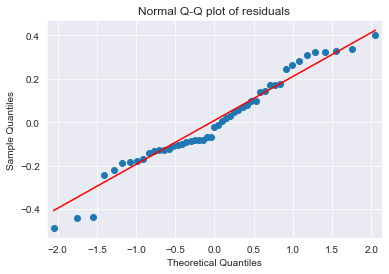

In [85]:
sm.qqplot(final_model.resid, line = 'q')
plt.title('Normal Q-Q plot of residuals')
plt.show()

#### Observation: Error should have Normal / Gaussian distribution~N(0,1) and idenpendently and identically distributed.

### Residual Plot for Homoscedasticity

In [86]:
def get_standardized_values( vals ):
    return (vals - vals.mean())/vals.std()

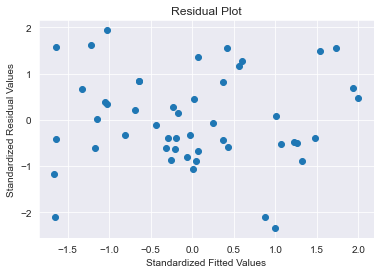

In [87]:
plt.scatter(get_standardized_values(final_model.fittedvalues), get_standardized_values(final_model.resid))
plt.title('Residual Plot')
plt.xlabel('Standardized Fitted Values')
plt.ylabel('Standardized Residual Values')
plt.show()

#### Observation: Constant Variance (Homoscedasticity) in Error
### Residual VS Regressors
* Plotting to visualize the partial relation of each independent feature with the Dependent variable and errors

eval_env: 1


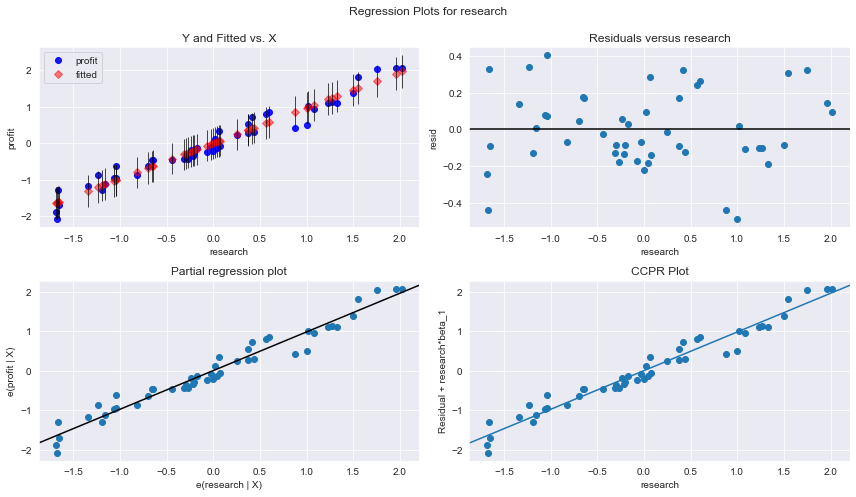

In [88]:
fig = plt.figure(figsize = (12,7))
plot_RnD = sm.graphics.plot_regress_exog(final_model, 'research', fig=fig)
plt.show()

#### Observation:
* Each Feature and Model Error (residuals) should be independent of each other
* There should be a linear relation between the dependent variable and Independent variables

**Note: All our assumptions are satisfied. Hence, we can say our model is a good model let us test more to make it even better**

### Detecting Influencers/Outliers in the Model
* By using Cook's Distance

In [89]:
influence_points = final_model.get_influence()
c, p_value = influence_points.cooks_distance

#### Leverage Value using High Influence Points : Points beyond Leverage_cutoff value are influencers

In [90]:
from statsmodels.graphics.regressionplots import influence_plot

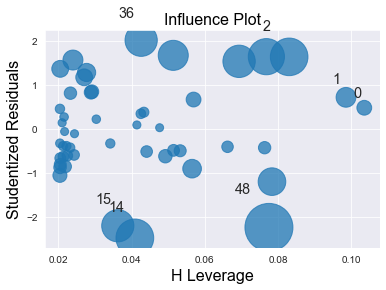

In [91]:
influence_plot(final_model)
plt.show()

### Leverage Cuttoff Value = 3*(k+1)/n ; k = no.of features/columns & n = no. of datapoints

In [92]:
k = startup_data4.shape[1]
n = startup_data4.shape[0]
leverage_cutoff = (3*(k+1))/n
print('Cut-off line at',np.round(leverage_cutoff,2))

Cut-off line at 0.31


### Let's plot the influencers and also plot a cut off line using the stem plot

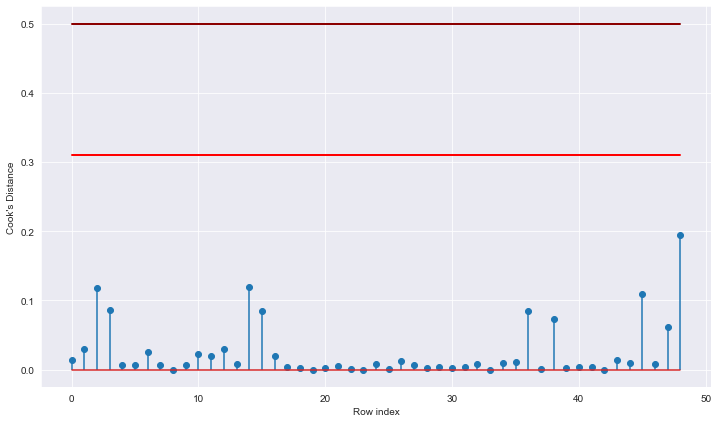

In [93]:
fig = plt.figure(figsize = (12,7))
x = [0,48]
y = [0.5,0.5]
plt.plot(x, y, color = 'darkred', linewidth = 2)
y1 = [0.31,0.31]
plt.plot(x , y1, color = 'red', linewidth = 2)
plt.stem(np.arange(len(startup_data4)), np.round(c,3))
plt.xlabel('Row index')
plt.ylabel("Cook's Distance")
plt.show()

#### Observation: All the points are below our cut-off line
* Hence, we can say that there are no influncers present in our model we can proceed with the predictions

### Predicting values from Model using same dataset

In [94]:
# Scale the test dataset
X_test_scaled = transformer_x.transform(startup_data4.research.values.reshape(-1,1))

# Predict with the trained model
prediction = regressor_linear_using_rnd.predict(X_test_scaled)

# Inverse transform the prediction
prediction_unscaled = transformer_y.inverse_transform(prediction)

In [95]:
predicted = pd.DataFrame(prediction_unscaled, columns=['Predicted_Profit'])
predicted['Profit'] = startup_data4.profit
predicted['RnD'] = startup_data4.research
predicted

,Predicted_Profit,Profit,RnD
0,188741.633166,192261.83,165349.20
1,186461.632949,191792.06,162597.70
2,178874.456794,191050.39,153441.51
3,171359.446810,182901.99,144372.41
4,169482.521463,166187.94,142107.34
5,161005.179859,156991.12,131876.90
6,163274.457488,156122.51,134615.46
7,159696.949460,155752.60,130298.13
8,151613.070514,152211.77,120542.52
9,153926.928921,149759.96,123334.88


### Table containing R^2 value for each prepared model

In [96]:
models={'Different_Models':['Raw_data','Median_Imputation_Outlier','Mean_Imputation_Outlier','Removed_Outlier','Using All Features Model','Using RnD and Marketing Feature Model','Using only R&D Feauture Model'],
        'R_squared':[raw_model.rsquared,median_imputation_model.rsquared,mean_imputation_model.rsquared,removed_outlier_model.rsquared,r2_score_all_feature_train,r2_score_rnd_and_marketing_train,r2_score_rnd_train],
        'R_squared_adjusted':[raw_model.rsquared_adj,median_imputation_model.rsquared_adj,mean_imputation_model.rsquared_adj,removed_outlier_model.rsquared_adj,model.rsquared_adj,marketing_present_model.rsquared_adj,research_model.rsquared_adj],
        'RMSE':[np.sqrt(raw_model.mse_resid),np.sqrt(median_imputation_model.mse_resid),np.sqrt(mean_imputation_model.mse_resid),np.sqrt(removed_outlier_model.mse_resid),rmse_linear_using_all_features,rmse_linear_using_RnD_and_marketing,rmse_linear_using_only_RnD]}
model_table = pd.DataFrame(models)
model_table

,Different_Models,R_squared,R_squared_adjusted,RMSE
0,Raw_data,0.950746,0.947534,9232.334837
1,Median_Imputation_Outlier,0.918296,0.912967,11148.345424
2,Mean_Imputation_Outlier,0.911954,0.906212,11570.325358
3,Removed_Outlier,0.961316,0.958737,7753.807752
4,Using All Features Model,0.961337,0.958737,8680.586928
5,Using RnD and Marketing Feature Model,0.960945,0.959394,8596.387517
6,Using only R&D Feauture Model,0.957733,0.956432,7152.417058


### Visualizing Models Performance

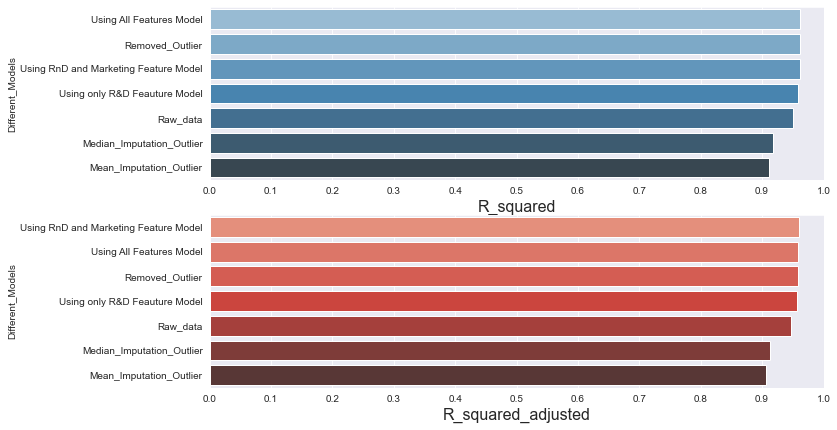

In [97]:
f, axes = plt.subplots(2,1, figsize=(11,7))

model_table.sort_values(by=['R_squared'], ascending=False, inplace=True)
sns.barplot(x='R_squared', y='Different_Models', data = model_table, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('R_squared', size=16)
axes[0].set_ylabel('Different_Models')
axes[0].set_xlim(0,1.0)
axes[0].set_xticks(np.arange(0, 1.1, 0.1))

model_table.sort_values(by=['R_squared_adjusted'], ascending=False, inplace=True)
sns.barplot(x='R_squared_adjusted', y='Different_Models', data = model_table, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('R_squared_adjusted', size=16)
axes[1].set_ylabel('Different_Models')
axes[1].set_xlim(0,1.0)
axes[1].set_xticks(np.arange(0, 1.1, 0.1))
plt.show()

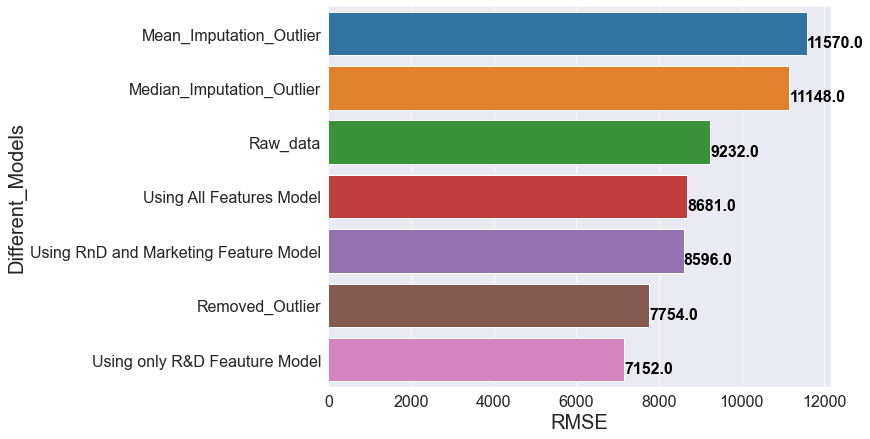

In [98]:
model_table.sort_values(by=['RMSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(9,7))
sns.barplot(x='RMSE', y='Different_Models', data=model_table, ax = axe)
axe.set_xlabel('RMSE', size=20)
axe.set_ylabel('Different_Models', size=20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

for i, v in enumerate(np.round(model_table.RMSE.values,0)):
    axe.text(v + 3, i + .25, str(v),
    color = 'black', fontweight = 'bold', fontsize= 16)
plt.show()

# The End !!!